In [1]:
# import libraries and data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.model_selection import train_test_split
import re

file_path = r'C:\Users\saman\physician-burnout-ml\Physician Burnout Survey.xlsx'
data = pd.read_excel(file_path)

In [2]:
# remove unecessary data and rename
clean_data = data.drop(columns=['Respondent ID', 'Collector ID', 'Start Date', 'End Date', 'IP Address', 'Email Address', 
                                'First Name', 'Last Name', 'Custom Data 1'])
clean_data = clean_data.drop(index=0, axis=0)
clean_data.columns=['Age', 'Gender', 'Specialty', 'Practice Type', 'Practice Size', 'New Patients', 'Years Worked',
                      'Patient Hours', 'EHR Hours', 'Admin Hours', 'Income Change', 'Burnout Level']

clean_data.dropna(subset=['Burnout Level'], inplace=True, how='any')

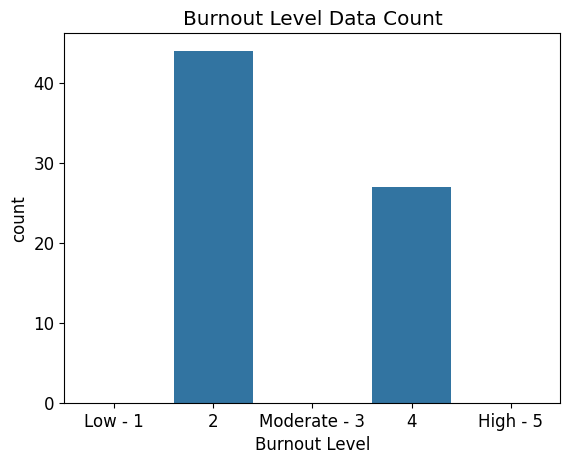

In [7]:
# bar graph of burnout levels count
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['savefig.dpi'] = 100
pyplot.rcParams.update({'font.size': 12})

fig1 = sns.countplot(x = 'Burnout Level', data = clean_data, order=['Low - 1', '2', 'Moderate - 3', '4', 'High - 5'])
pyplot.title('Burnout Level Data Count')
burnout_count = fig1.get_figure()

In [8]:
# cleaning words from burnout level
def extractNum(text):
    if isinstance(text, int):
        return text
    
    num = re.findall(r'\d+', str(text))
    return int(num[0])

clean_data['Burnout Level'] = clean_data['Burnout Level'].apply(extractNum)

In [9]:
# fixing hours columns for graphing
patHours = ["Less than 20", "20-29", "30-39", "40-49", "50+"]
EHR_AdmHours = ["Less than 5", "5-10", "11-15", "16+"]
years = ["Last 12 months", "1-5 years", "6-10 years", "11-15 years", "16+ years"]
fixedPat = [10, 24.5, 34.5, 44.5, 50]
fixedEHRAdm = [2, 7.5, 13, 16]
fixedYears = [0, 3, 8, 13, 16]

# changes hours to ints that are average of the range
def fixHours(time, ogTime, fixTo):
    for i in range(len(ogTime)):
        if(ogTime[i] == time):
            return fixTo[i]
    return time

graph_data = clean_data.copy()

graph_data['Patient Hours'] = graph_data['Patient Hours'].apply(lambda hours: fixHours(hours, patHours, fixedPat))
graph_data['EHR Hours'] = graph_data['EHR Hours'].apply(lambda hours: fixHours(hours, EHR_AdmHours, fixedEHRAdm))
graph_data['Admin Hours'] = graph_data['Admin Hours'].apply(lambda hours: fixHours(hours, EHR_AdmHours, fixedEHRAdm))
graph_data['Years Worked'] = graph_data['Years Worked'].apply(lambda year: fixHours(year, years, fixedYears))

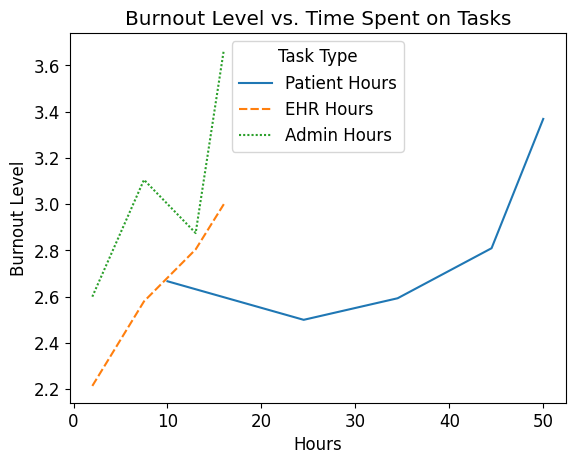

In [ ]:
# graph of burnout correlated to hours on ehr, admin, and seeing patients
melted = graph_data.melt(id_vars='Burnout Level', 
                         value_vars=['Patient Hours', 'EHR Hours', 'Admin Hours'],
                         var_name='Task Type', 
                         value_name='Hours')

sns.lineplot(data=melted, x='Hours', y='Burnout Level', hue='Task Type', style='Task Type', errorbar=None)
pyplot.title('Burnout Level vs. Time Spent on Tasks')
pyplot.show()

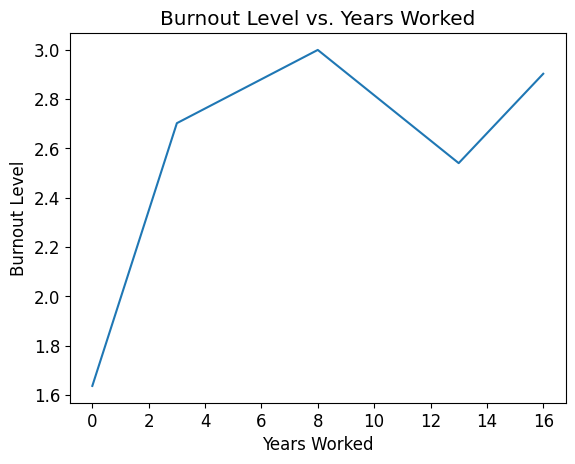

In [11]:
# lineplot for years worked
fig2 = sns.lineplot(data=graph_data, x='Years Worked', y='Burnout Level', errorbar=None)
pyplot.title("Burnout Level vs. Years Worked")
years_graph = fig2.get_figure()

In [59]:
# splitting data
y = clean_data[['Burnout Level']].copy()
X = clean_data.drop(columns=['Burnout Level'])

In [60]:
# collapsed burnout level to low, medium, high
def collapse(level):
    if(level == 1 or level == 2):
        return "Low"
    if(level == 3):
        return "Moderate"
    if(level == 4 or level == 5):
        return "High"
    return level

y['Burnout Level'] = y['Burnout Level'].apply(lambda level: collapse(level))

In [61]:
# split train and test data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
# more data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [ ]:
# model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=80, random_state=3)

In [94]:
clf.fit(X_train_encoded, y_train)
y_preds = clf.predict(X_test_encoded)

In [95]:
clf.score(X_test_encoded, y_test)

0.46153846153846156

In [96]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

        High       0.25      0.14      0.18         7
         Low       0.48      0.62      0.54        16
    Moderate       0.50      0.44      0.47        16

    accuracy                           0.46        39
   macro avg       0.41      0.40      0.40        39
weighted avg       0.45      0.46      0.45        39



In [85]:
# tuning hyperparameters, n_estimators
np.random.seed(3)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
for i in range(10, 100, 10):
    print(f"Trying {i} estimators:")
    clf = RandomForestClassifier(n_estimators=i, random_state=3).fit(X_train_encoded, y_train)
    print(f"score: {clf.score(X_test_encoded, y_test)}")
    print("")

Trying 10 estimators:
score: 0.38461538461538464

Trying 20 estimators:
score: 0.38461538461538464

Trying 30 estimators:
score: 0.358974358974359

Trying 40 estimators:
score: 0.28205128205128205

Trying 50 estimators:
score: 0.38461538461538464

Trying 60 estimators:
score: 0.3333333333333333

Trying 70 estimators:
score: 0.4358974358974359

Trying 80 estimators:
score: 0.46153846153846156

Trying 90 estimators:
score: 0.358974358974359



In [89]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 25, 50, 75, 100, 200],
    'min_samples_split': [2, 5],
    'min_impurity_decrease': [0.0, 0.001, 0.005]
}

grid = GridSearchCV(RandomForestClassifier(random_state=3, n_estimators=80), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train_encoded, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score: 0.4616935483870968


In [91]:
grid.score(X_test_encoded, y_test)

0.358974358974359

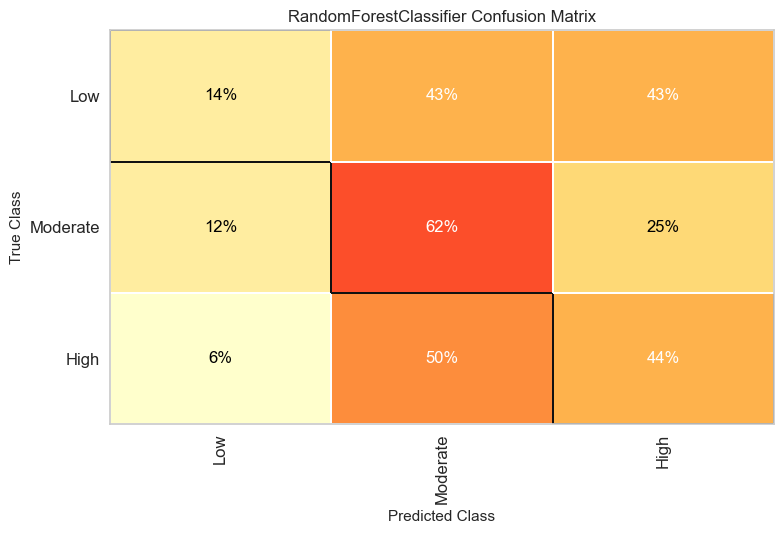

In [ ]:
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError

classes = ['Low', 'Moderate', 'High']
cm = ConfusionMatrix(
clf, classes=classes,
percent=True, label_encoder={0: 'Low', 1: 'Moderate', 2: 'High'})

cm.fit(X_train_encoded, y_train)
cm.score(X_test_encoded, y_test)

cm.show()

for label in cm.ax.texts:
    label.set_size(22)

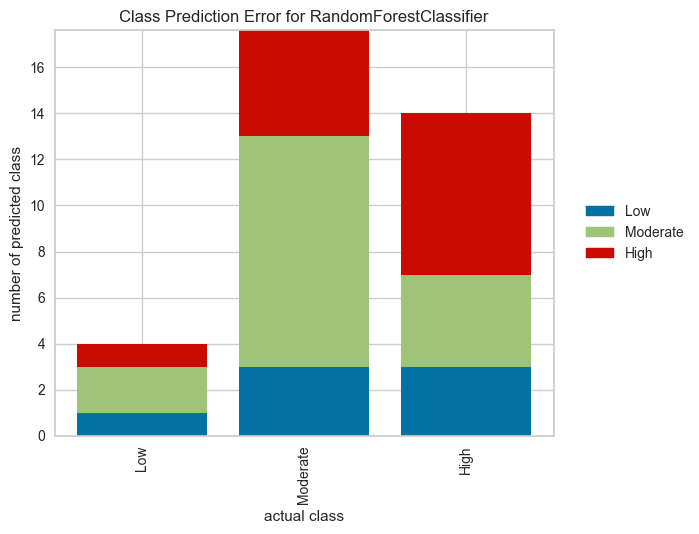

In [ ]:
# graph of class prediction error
classes = ['Low', 'Moderate', 'High']
visualizer = ClassPredictionError(clf, classes=classes)
visualizer.fit(X_train_encoded, y_train)
visualizer.score(X_test_encoded, y_test)
visualizer.show()